# EDA 05 — Multivariable structure (PCA & t-SNE)

This notebook explores the multivariable structure of the descriptor space:

- Linear structure via PCA
- Non-linear structure via t-SNE
- Label information is used for visualization only (never for fitting)
- Comparison between:
  - Full feature set
  - Pruned feature set (ρ ≥ 0.80)

This analysis is exploratory and intended to assess global separability patterns,
not classification performance.

In [1]:
from __future__ import annotations

from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
sns.set_context("notebook")
sns.set_style("whitegrid")

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 300

PROJECT_ROOT = Path("../../").resolve()

DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed_variants"
STRICT_CSV  = DATA_PROCESSED_DIR / "hcs_strict_complete_case_20260129_114259.csv"
IMPUTED_CSV = DATA_PROCESSED_DIR / "hcs_imputed_exploratory_20260129_114259.csv"

EDA_ROOT = PROJECT_ROOT / "results" / "eda"
FIG_DIR = EDA_ROOT / "figures" / "multivariable"
STATS_DIR = EDA_ROOT / "stats"

FIG_DIR.mkdir(parents=True, exist_ok=True)
STATS_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
df_strict = pd.read_csv(STRICT_CSV)
df_imputed = pd.read_csv(IMPUTED_CSV)

print("STRICT:", df_strict.shape)
print("IMPUTED:", df_imputed.shape)

STRICT: (148, 15)
IMPUTED: (160, 15)


In [5]:
LABEL_COL = "MSPH"     

META_COLS = [
    "row_id", "_sheet", "LocalID"	
]

def resolve_features(df: pd.DataFrame) -> List[str]:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    blacklist = set(META_COLS + [LABEL_COL])
    return [c for c in numeric_cols if c not in blacklist]

feat_strict = resolve_features(df_strict)
feat_imputed = resolve_features(df_imputed)

common_features = sorted(list(set(feat_strict).intersection(set(feat_imputed))))
print("Common features:", len(common_features))


Common features: 11


In [6]:
def load_feature_list(path: Path) -> List[str]:
    df = pd.read_csv(path)
    return df["feature"].astype(str).tolist()

full_features = load_feature_list(STATS_DIR / "feature_set_full_used_in_nb04.csv")
pruned_features = load_feature_list(STATS_DIR / "feature_set_pruned_union_thr0.80_used_in_nb04.csv")

full_features = [f for f in full_features if f in common_features]
pruned_features = [f for f in pruned_features if f in common_features]

print("Full:", len(full_features))
print("Pruned:", len(pruned_features))


Full: 11
Pruned: 9


In [7]:
def build_X_y(
    df: pd.DataFrame,
    features: List[str],
    label_col: str,
) -> Tuple[np.ndarray, np.ndarray]:
    X = df[features].apply(pd.to_numeric, errors="coerce")
    y = df[label_col].to_numpy()

    # drop rows with any NaN
    mask = ~X.isna().any(axis=1)
    X = X.loc[mask]
    y = y[mask]

    X = StandardScaler().fit_transform(X)
    return X, y


In [8]:
def run_pca(X: np.ndarray, n_components: int = 2) -> Tuple[np.ndarray, PCA]:
    pca = PCA(n_components=n_components, random_state=42)
    Z = pca.fit_transform(X)
    return Z, pca

In [9]:
Xf_s, y_s = build_X_y(df_strict, full_features, LABEL_COL)
Xp_s, _   = build_X_y(df_strict, pruned_features, LABEL_COL)

Zf_s, pca_f = run_pca(Xf_s)
Zp_s, pca_p = run_pca(Xp_s)

print("Explained variance (Full):", pca_f.explained_variance_ratio_)
print("Explained variance (Pruned):", pca_p.explained_variance_ratio_)

Explained variance (Full): [0.25379904 0.18008515]
Explained variance (Pruned): [0.22512961 0.19036013]


In [10]:
def plot_2d(Z, y, title, outpath):
    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        x=Z[:, 0],
        y=Z[:, 1],
        hue=y,
        palette="Set1",
        s=60,
        alpha=0.8,
    )
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.legend(title="Label")
    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()

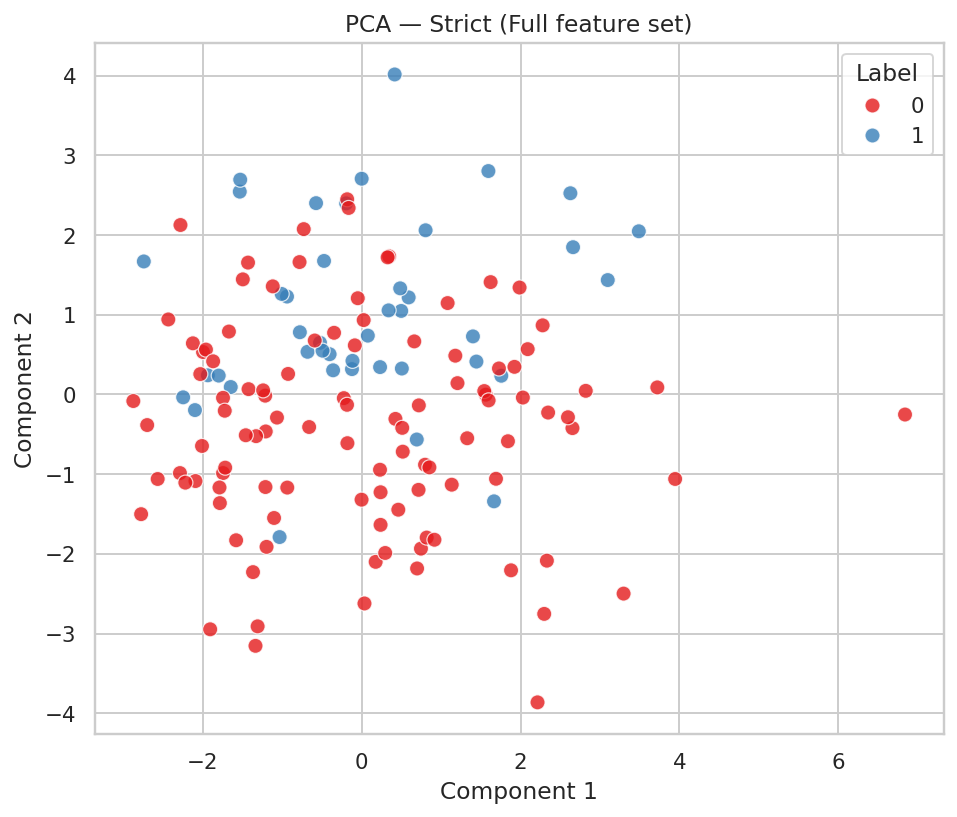

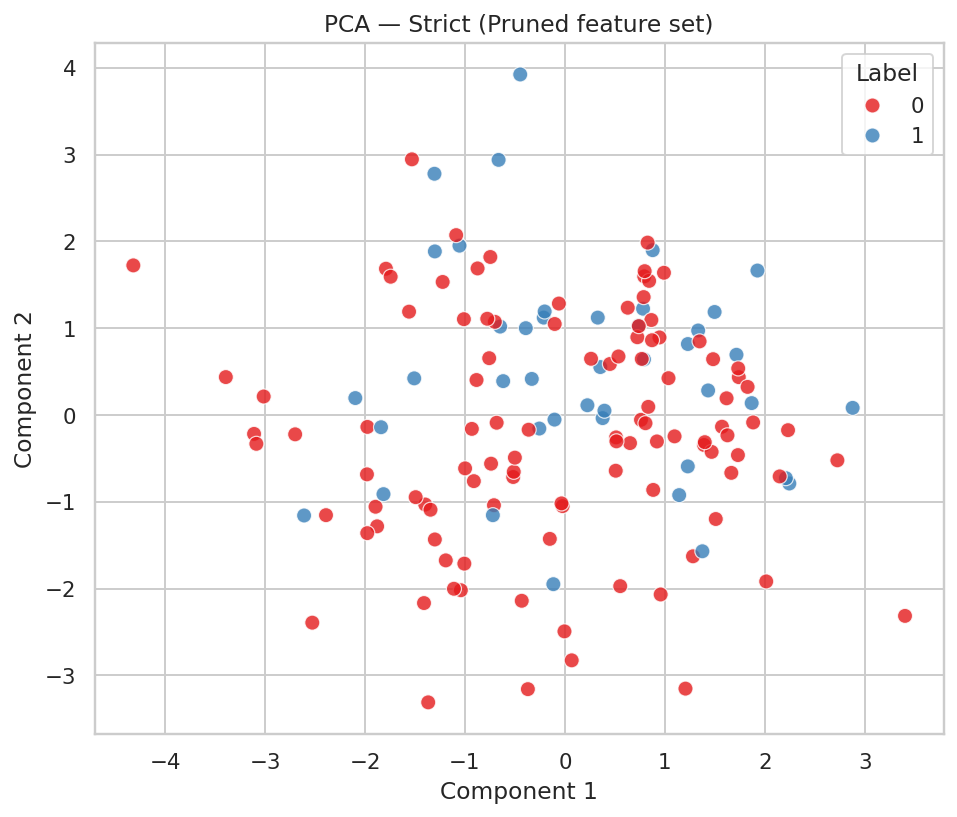

In [11]:
plot_2d(
    Zf_s, y_s,
    "PCA — Strict (Full feature set)",
    FIG_DIR / "pca_strict_full.png",
)

plot_2d(
    Zp_s, y_s,
    "PCA — Strict (Pruned feature set)",
    FIG_DIR / "pca_strict_pruned.png",
)


In [14]:
def run_tsne(
    X: np.ndarray,
    perplexity: int = 15,
) -> np.ndarray:
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init="pca",
        learning_rate="auto",
        random_state=42,
    )
    return tsne.fit_transform(X)


In [15]:
Zf_tsne = run_tsne(Xf_s, perplexity=15)
Zp_tsne = run_tsne(Xp_s, perplexity=15)

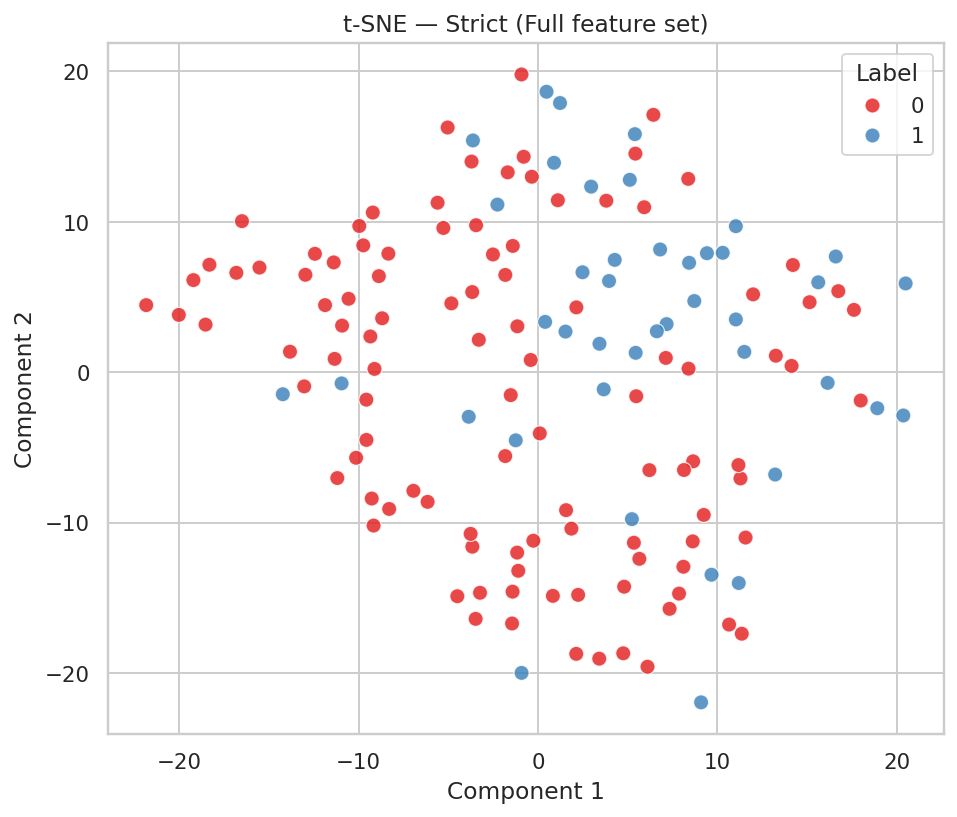

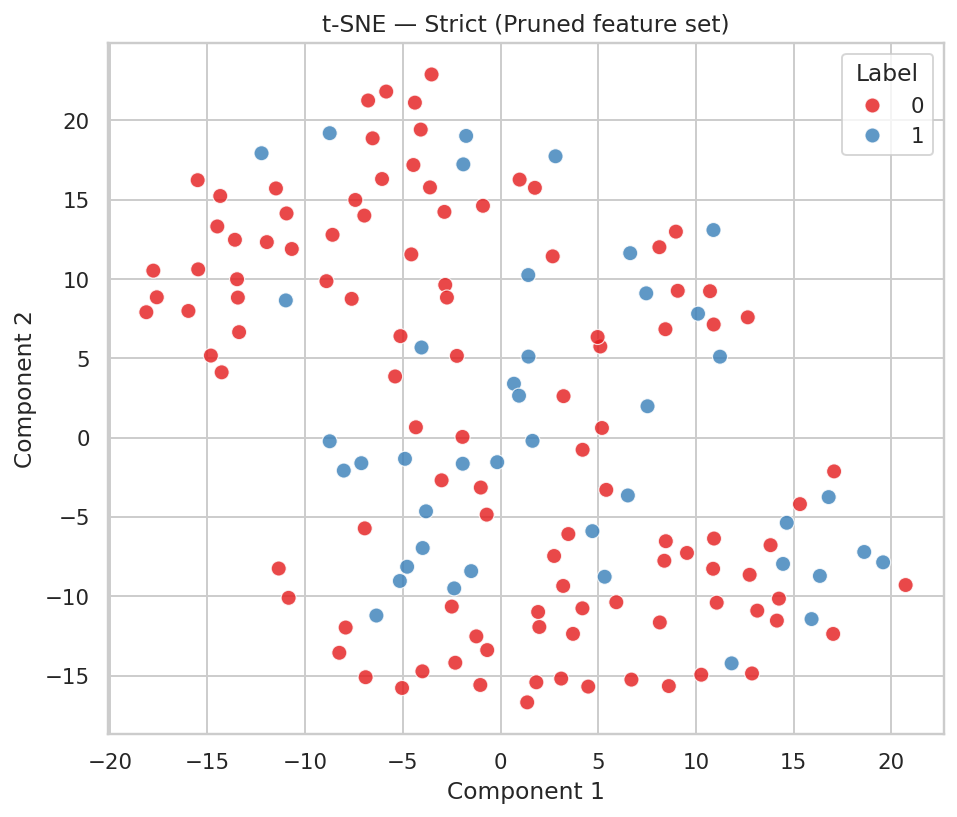

In [16]:
plot_2d(
    Zf_tsne, y_s,
    "t-SNE — Strict (Full feature set)",
    FIG_DIR / "tsne_strict_full.png",
)

plot_2d(
    Zp_tsne, y_s,
    "t-SNE — Strict (Pruned feature set)",
    FIG_DIR / "tsne_strict_pruned.png",
)


## Interpretation notes

- PCA:
  - Shows whether linear combinations of descriptors separate labels.
  - Overlap indicates weak linear separability.

- t-SNE:
  - Highlights potential non-linear structure.
  - Apparent separation must be interpreted cautiously.

- Consistency between Full and Pruned representations suggests robustness.
- These analyses are exploratory and do not imply predictive performance.